## 데이터 전처리

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub Version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")


Version:  2.8.0
Eager mode:  True
Hub Version:  0.12.0
GPU is available


In [3]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

import os
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image_dataset_from_directory

os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
os.environ["TF_CPP_VMODULE"]="gpu_process_state=10,gpu_cudamallocasync_allocator=10"

### 데이터 로드

In [5]:
PATH = '/mnt/data/prep_data_splited'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')
test_dir = os.path.join(PATH, 'test')

img_height = 160
img_width = 160
BATCH_SIZE = 32
IMG_SIZE = (img_height, img_width)

In [6]:
train_dataset = image_dataset_from_directory(train_dir,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                shuffle=True,
                                                batch_size=BATCH_SIZE,
                                                image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory(test_dir,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

Found 6887 files belonging to 4 classes.
Found 859 files belonging to 4 classes.
Found 865 files belonging to 4 classes.


In [7]:
class_names = train_dataset.class_names
print(class_names)

['autumn', 'spring', 'summer', 'winter']


In [8]:
## 데이터셋에 테스트 데이터가 따로 없기 때문에, 검증 데이터셋 중 20%를 테스트 데이터로 떼어 놓는다.
## 현재는 validation 데이터를 따로 분리했기 때문에 필요없음.
# val_batches = tf.data.experimental.cardinality(validation_dataset)
# test_dataset = validation_dataset.take(val_batches // 5)
# validation_dataset = validation_dataset.skip(val_batches // 5)
# print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
# print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

### 성능을 높이도록 데이터세트 구성하기

In [9]:
# buffered prefecthing을 사용해 I/O에 막힘 없이 이미지를 디스크에서 읽어올 수 있도록 한다.
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### 데이터 증강

In [10]:
# data augmentation을 통해 overfitting을 방지하고, 성능을 향상할 수 있도록 한다.
# Data Augmentation은 레이어로 구성하여 model.fit을 통해 호출할 때 적용되도록 할 수 있다.
# model.evaluate 혹은 model.predict 등 추론을 할 때에는 이런 augmentation layer은 활성화되지 않는다.
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),  
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

### 픽셀 값 재조정

In [11]:
# 모바일넷 v2는 픽셀 값이 [-1 , 1] 사이에 있는 인풋을 받는다. 
# [0,255] 값을 [-1,1] 사이로 변환하는 레이어를 직접 만들어야 한다. 
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

## 사전 훈련된 컨볼루션 네트워크로부터 기본 모델 생성하기

In [12]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

이 특징 추출기는 각 160x160x3 이미지를 5x5x1280 개의 특징 블록으로 변환합니다.

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## 특징 추출

### 컨볼루션 베이스 모델 고정하기
- BatchNormalization 레이어에 대한 중요 참고 사항

많은 모델에는 tf.keras.layers.BatchNormalization 레이어가 포함되어 있습니다. 이 레이어는 특별한 경우이며 이 튜토리얼의 뒷부분에 나와 있는 것처럼 미세 조정의 맥락에서 주의를 기울여야 합니다.

layer.trainable = False를 설정하면 BatchNormalization 레이어가 추론 모드에서 실행되고 평균 및 분산 통계를 업데이트하지 않습니다.

미세 조정을 위해 BatchNormalization 레이어를 포함하는 모델을 동결 해제하면 기본 모델을 호출할 때 training = False를 전달하여 BatchNormalization 레이어를 추론 모드로 유지해야 합니다. 그렇지 않으면 훈련 불가능한 가중치에 적용된 업데이트로 인해 모델이 학습한 내용이 파괴됩니다.

자세한 내용은 [전이 학습 가이드](https://www.tensorflow.org/guide/keras/transfer_learning?hl=ko)를 참조하세요.

In [14]:
base_model.trainable = False
# 기본 모델 아키텍처를 살펴봅니다.
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

### 분류 층을 맨 위에 추가하기

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [16]:
prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [17]:
normalized_ds = train_dataset.map(lambda x, y: (rescale(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

-1.0 1.0


In [18]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### 모델 컴파일

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
len(model.trainable_variables)

2

## 모델 훈련

In [21]:
loss0, accuracy0 = model.evaluate(validation_dataset)

27/27 [==============================] - 2s 29ms/step - loss: 1.6390 - accuracy: 0.2608


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.64
initial accuracy: 0.26


In [23]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', 
                                min_delta = 0, 
                                patience = 5, 
                                mode = 'auto'
                                )

In [24]:
initial_epochs = 1000

In [29]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset, 
                    verbose=2,
                    callbacks = [early_stopping]
                    )

Epoch 1/1000
216/216 - 5s - loss: 1.0828 - accuracy: 0.5220 - val_loss: 1.0866 - val_accuracy: 0.5297 - 5s/epoch - 21ms/step
Epoch 2/1000
216/216 - 4s - loss: 1.0787 - accuracy: 0.5309 - val_loss: 1.0805 - val_accuracy: 0.5320 - 4s/epoch - 21ms/step
Epoch 3/1000
216/216 - 5s - loss: 1.0682 - accuracy: 0.5387 - val_loss: 1.0796 - val_accuracy: 0.5332 - 5s/epoch - 21ms/step
Epoch 4/1000
216/216 - 5s - loss: 1.0634 - accuracy: 0.5346 - val_loss: 1.0729 - val_accuracy: 0.5343 - 5s/epoch - 21ms/step
Epoch 5/1000
216/216 - 5s - loss: 1.0517 - accuracy: 0.5429 - val_loss: 1.0719 - val_accuracy: 0.5402 - 5s/epoch - 21ms/step
Epoch 6/1000
216/216 - 5s - loss: 1.0494 - accuracy: 0.5494 - val_loss: 1.0692 - val_accuracy: 0.5355 - 5s/epoch - 21ms/step
Epoch 7/1000
216/216 - 4s - loss: 1.0414 - accuracy: 0.5509 - val_loss: 1.0656 - val_accuracy: 0.5332 - 4s/epoch - 21ms/step
Epoch 8/1000
216/216 - 5s - loss: 1.0345 - accuracy: 0.5582 - val_loss: 1.0640 - val_accuracy: 0.5483 - 5s/epoch - 21ms/step


### 학습 곡선

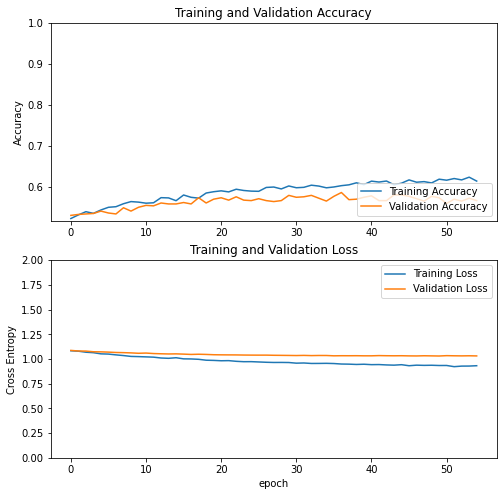

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)
print('\nTest accuracy:', test_acc)

28/28 - 1s - loss: 0.9958 - accuracy: 0.5908 - 625ms/epoch - 22ms/step

Test accuracy: 0.5907514691352844


In [33]:
model.save('models/mobilenet_v2.h5')

In [54]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_dataset,batch_size=BATCH_SIZE) 

print('Predictions:\n', predictions.argmax(axis=1)[:32])
print('Labels:\n', label_batch)

Predictions:
 [0 3 2 3 3 2 0 3 0 3 2 0 0 3 0 3 3 3 3 0 0 0 0 3 1 0 0 0 3 3 0 3]
Labels:
 [1 0 3 3 0 0 0 1 0 3 3 3 3 0 0 3 0 3 3 3 0 0 2 2 2 3 2 3 1 3 0 0]


In [90]:
tf.math.confusion_matrix(
    label_batch, predictions.argmax(axis=1)[:32], num_classes=None, weights=None, dtype=tf.dtypes.int32,
    name=None
)

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[4, 3, 0, 6],
       [4, 0, 1, 1],
       [1, 0, 0, 3],
       [2, 1, 2, 4]], dtype=int32)>

In [91]:
predictions = probability_model.predict(test_dataset)

In [92]:
print(test_dataset.class_names)
predictions[0]

['autumn', 'spring', 'summer', 'winter']


array([0.2154605 , 0.10854557, 0.55007595, 0.12591802], dtype=float32)

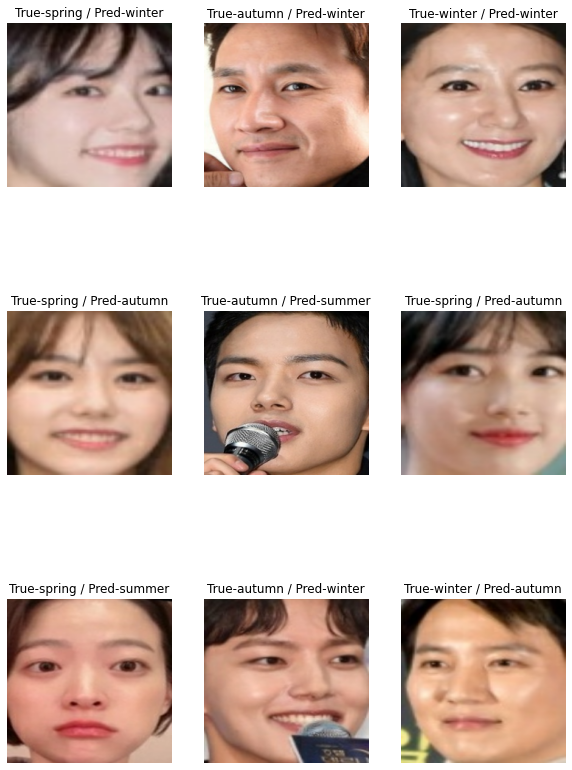

In [94]:
plt.figure(figsize=(10, 15))
test_batch = test_dataset.take(1)
predictions = probability_model.predict(test_batch) 
pred = predictions.argmax(axis=1)

for images, labels in test_batch:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("True-{} / Pred-{}".format(class_names[labels[i]], class_names[pred[i]]))
        plt.axis("off")

## 다른 모델

In [39]:
num_classes = 4

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [40]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [41]:
history = model.fit(
                    train_dataset,
                    validation_data=validation_dataset,
                    epochs=10
                    )

Epoch 1/10
224/224 [==============================] - 5s 19ms/step - loss: 1.3043 - accuracy: 0.3802 - val_loss: 1.2734 - val_accuracy: 0.4145
Epoch 2/10
224/224 [==============================] - 4s 18ms/step - loss: 1.2250 - accuracy: 0.4258 - val_loss: 1.2808 - val_accuracy: 0.3762
Epoch 3/10
224/224 [==============================] - 4s 18ms/step - loss: 1.1340 - accuracy: 0.4936 - val_loss: 1.2686 - val_accuracy: 0.3899
Epoch 4/10
224/224 [==============================] - 4s 18ms/step - loss: 1.0225 - accuracy: 0.5618 - val_loss: 1.3111 - val_accuracy: 0.4542
Epoch 5/10
224/224 [==============================] - 4s 18ms/step - loss: 0.8277 - accuracy: 0.6579 - val_loss: 1.5136 - val_accuracy: 0.4405
Epoch 6/10
224/224 [==============================] - 4s 18ms/step - loss: 0.5826 - accuracy: 0.7790 - val_loss: 1.9409 - val_accuracy: 0.4254
Epoch 7/10
224/224 [==============================] - 4s 18ms/step - loss: 0.3438 - accuracy: 0.8769 - val_loss: 2.6005 - val_accuracy: 0.3803

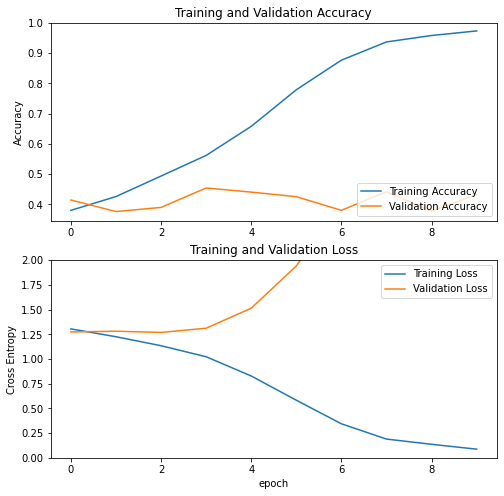

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## ResNet

In [19]:
resnet50_pre =  tf.keras.applications.resnet50.ResNet50(weights= 'imagenet', 
                                                        include_top=False, 
                                                        input_shape= (224, 224, 3))
resnet50_pre.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [29]:
from tensorflow.keras.applications.imagenet_utils import decode_predictions
import cv2

In [21]:
def pred_img(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    img_resized = cv2.resize(img, (224, 224))
    pred = resnet50_pre.predict(img_resized.reshape([1, 224,224, 3]))
    decoded_pred = decode_predictions(pred)

    for i, instance in enumerate(decoded_pred[0]):
        print('{}위: {} ({:.2f})%'.format(i+1, instance[1], instance[2]*100))

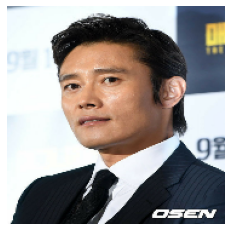

2022-03-07 05:56:11.008879: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201


ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: (1, 7, 7, 2048)

In [30]:
pred_img(image)

In [44]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = global_average_layer(inputs)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(4)(x)
model = tf.keras.Model(inputs, outputs)

In [45]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [46]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/30
224/224 [==============================] - 4s 15ms/step - loss: 43.1695 - accuracy: 0.3112 - val_loss: 19.7846 - val_accuracy: 0.2914
Epoch 2/30
224/224 [==============================] - 3s 15ms/step - loss: 17.9153 - accuracy: 0.2862 - val_loss: 6.1078 - val_accuracy: 0.2681
Epoch 3/30
224/224 [==============================] - 3s 15ms/step - loss: 9.3453 - accuracy: 0.2855 - val_loss: 3.6708 - val_accuracy: 0.2736
Epoch 4/30
224/224 [==============================] - 3s 15ms/step - loss: 3.3973 - accuracy: 0.3093 - val_loss: 1.3701 - val_accuracy: 0.3858
Epoch 5/30
224/224 [==============================] - 3s 15ms/step - loss: 1.3717 - accuracy: 0.3416 - val_loss: 1.3608 - val_accuracy: 0.3680
Epoch 6/30
224/224 [==============================] - 3s 15ms/step - loss: 1.3709 - accuracy: 0.3429 - val_loss: 1.3786 - val_accuracy: 0.2709
Epoch 7/30
224/224 [==============================] - 3s 15ms/step - loss: 1.3775 - accuracy: 0.3517 - val_loss: 1.4931 - val_accuracy: 0.1

KeyboardInterrupt: 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)
print('\nTest accuracy:', test_acc)